In [1]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav

import matplotlib
# matplotlib.use('GTKAgg')
import matplotlib.pyplot as plt
%matplotlib inline

import librosa, librosa.display

import time, operator
# import pylab as pl
from IPython import display

from io import BytesIO
from PIL import Image

import torch
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.datasets as dset

from deepdream import util as ddutil
from deepdream import resnet as ddresnet
from deepdream.deepdream import dream

In [2]:
def objective_guide(dst, guide_features):
    x = dst.data[0].cpu().numpy().copy()
    y = guide_features.data[0].cpu().numpy()
    ch, w, h = x.shape
    x = x.reshape(ch,-1)      # (c，w*h)
    y = y.reshape(ch,-1)      # (c, w*h)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    result = y[:,A.argmax(1)] # select ones that match best
    result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float))
    return result

In [3]:
def stream_spectrogram(sound_in, sr):
    
    y = sound_in
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    buffer_ = BytesIO()
    
    plt.ioff()
    librosa.display.specshow(librosa.power_to_db(S,ref=np.max))
    plt.axis('off') # Removes black border
    plt.tight_layout()
    plt.savefig(buffer_,bbox_inches='tight',pad_inches=-0.05,transparency=True, format='jpg')
    image = Image.open(buffer_)
    plt.close()
    buffer_.seek(0)
    #ar = np.asarray(image)
    return image
    buffer_.close()

In [4]:
def classify_sound(image,resnet):
    
    resnet.eval()
    predictions = {}
    # Try your own image here.
    inputVar =  Variable(transform(image).unsqueeze(0))
    predictions = resnet(inputVar.cpu())

    probs, indices = (-F.softmax(predictions.cpu())).data.sort()
    probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
    preds = {class_dict[idx]:prob for (prob, idx) in zip(probs,indices)}
    preds = sorted(preds.items(), key=operator.itemgetter(1), reverse=True)
    
    #preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]
    #print(preds)
    #plt.title('\n'.join(preds))
    #plt.imshow(image);
    return preds

In [5]:
resnet = models.resnet50(pretrained = True)
print(resnet.fc)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
print(resnet.fc)

Linear (2048 -> 1000)
Linear (2048 -> 10)


In [6]:
resnet.load_state_dict(torch.load('../../../data/resnet50_v2_melspect_15_968.pt',
                                         map_location=lambda storage, 
                                         loc: storage
                                        )
                             )

transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])

In [7]:
class_dict = {0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jack_hammer',
 8: 'siren',
 9: 'street_music'}

In [63]:
# base_dream_path = './deepdream/data/target/'
class_img_path = './deepdream/data/base/render_classes/'
img_id = 0

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])

dream_transform = transforms.Compose([
    transforms.Scale((300)),
    transforms.CenterCrop(224),
    transforms.Scale((400)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dream_set = dset.ImageFolder(class_img_path,transform=dream_transform)

dset_loader = torch.utils.data.DataLoader(dream_set, batch_size=1)
deepdream_img_dict = dset_loader.dataset.class_to_idx

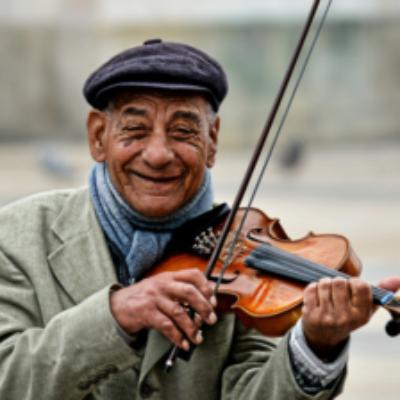

In [64]:
# t0 = time.time()
return_img = 'street_music'

dd_idx = deepdream_img_dict[return_img]
inputs = dset_loader.dataset[dd_idx][0].unsqueeze(0)
input_np = inputs.numpy()

ddutil.showtensor(input_np)

# tn = time.time()
# print(tn-t0)

In [65]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'

# load the model
dream_model = ddresnet.resnet50(pretrained=True)
dream_model.cpu()
# model = torch.nn.DataParallel(model, device_ids=[0, 1])
for param in dream_model.parameters():
    param.require_grads = False

In [66]:
class_colors = {"air_conditioner":"#0164cd",
                "car_horn":"#00a069",
                "children_playing":"#e44caa",
                "dog_bark":"#c2c331",
                "drilling":"#00b4f5",
                "engine_idling":"#007008",
                "gun_shot":"#b00036",
                "jack_hammer":"#bfa2ff",
                "siren":"#c35d03",
                "street_music":"#ff8765"
               }

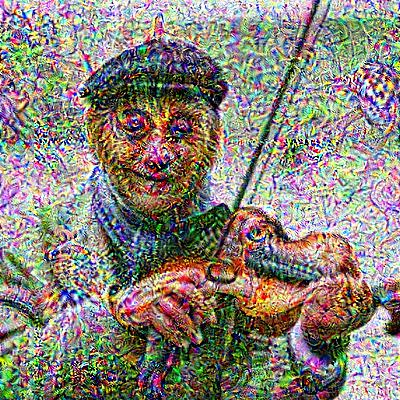

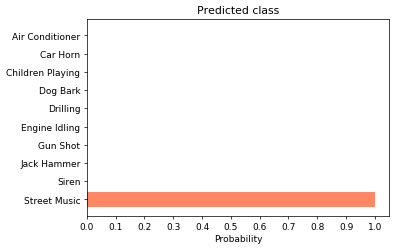

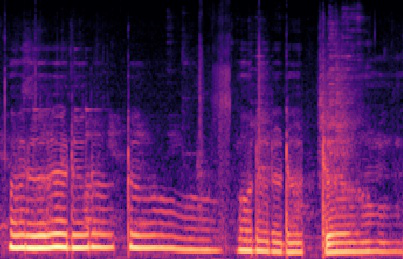

In [76]:
duration = 4
sr=44100

plot_predictions = True
display_spect = True
use_deepdream = True
deep_spect = False
fractal = False

# Deepdream parameters
octaves = 3
iterations = 2
use_gpu = False
jitter = 1000
sample_resolution = 1
f_layer = 3
lr=0.4

# t0 = time.time()
# while True:
for i in range(10):
    try:
        display.clear_output(wait=True)
        
        mic_recording = sd.rec(int(duration * sr), samplerate=sr, channels=2,dtype='float64')
        sd.wait()
        spect = stream_spectrogram(mic_recording[:,0],sr)
        preds = classify_sound(spect,resnet)
        
        # Select image
        return_img = preds[0][0]
        dd_idx = deepdream_img_dict[return_img]
        input_np = dset_loader.dataset[dd_idx][0].unsqueeze(0).numpy()
        inputs_guide = dset_loader.dataset[dd_idx][0].unsqueeze(0)

        
        # Deep Dream
        if fractal:
            #lr = float(preds[0][1])
            lr = .2
            X_Variable = Variable(inputs_guide.cpu())
            guide_features = dream_model.forward(X_Variable, n_layer=3)
        if use_deepdream:
            if deep_spect: input_np = transform(spect).unsqueeze(0).numpy()
            
            if fractal:
                dream(dream_model, input_np, octave_n=octaves, num_iterations=iterations, 
                      lr=lr, max_jitter=jitter, show_every=sample_resolution,end_layer=f_layer,
                      use_gpu=use_gpu,stream_out=True, 
                      objective=objective_guide, guide_features=guide_features
                     )
            else:
                dream(dream_model, input_np, octave_n=octaves, num_iterations=iterations, 
                      lr=lr, max_jitter=jitter, show_every=sample_resolution,end_layer=f_layer,
                      use_gpu=use_gpu,stream_out=True
                     )
            
        if plot_predictions:
            fig, ax = plt.subplots(figsize=(6,4),dpi=65)
            vals = [preds[p][1] for p in range(0, len(preds))]
            labls = [preds[p][0].replace('_',' ').title() for p in range(0, len(preds))]
            colors = [class_colors[preds[p][0]] for p in range(0, len(preds))]
            ax.barh(labls,vals,align='center',color=colors)
            ax.invert_yaxis()
            ax.set_xlabel('Probability')
            ax.set_title('Predicted class')
            ax.set_xticks(np.arange(0, 1.1, 0.1))
            plt.show()
            plt.clf()
            plt.cla()
            plt.close()
        
        #display.display(preds)
        if display_spect:
            display.display(spect)
        
        time.sleep(.0001)
    except KeyboardInterrupt:
        break
        
# tn = time.time()
# print(tn-t0)